# Testing the optimization run for convergence:

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pymoo.factory import (
    get_performance_indicator,
)  # Used to calculate hypervolume from archivelogged solutions

In [2]:
import matplotlib
import matplotlib.font_manager as fm

# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

from matplotlib import rcParams

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

## Hypervolume:

First read the runtime file from the outputs:

In [3]:
with open("../experimentation/borg_optimization/runtime/runtime_seed_10.txt") as f:
    contents = f.readlines()

In [4]:
nfe_archive = dict()

for i, line in enumerate(contents):
    
    if line[:5] == "//NFE":
        
        nfe_count = int(line[6:-1])
        j = i + 1 # With this index, scan lines below //NFE:
        batch_of_this_nfe = list()
        
        while j < len(contents) and contents[j][:5] != "//NFE":
            batch_of_this_nfe.append(contents[j])
            j += 1
        
        objective_tuples = []
        
        for obj_line in batch_of_this_nfe:
            if obj_line[0] == " ": # This means we are a line with obj values
                objective_tuples.append(tuple([round(float(x), 2) for x in obj_line.split()]))
                
        nfe_archive[nfe_count] = objective_tuples
                

In [5]:
# latest_archive = nfe_archive[max(nfe_archive.keys())]

best = [
    100,
    0,
    100,
    0,
]  # Initialize the set of best values with really bad results (the aim is to reach the real best with the for loop)
worst = [0, -190, 0, -20]  # Same idea, initialize the worst as something very good

for archive_set in nfe_archive.values():
    
    for objective_index in range(4):
        obj_values = [solution[objective_index] for solution in archive_set]
        minimum = min(obj_values)
        maximum = max(obj_values)
        if minimum < best[objective_index]:
            best[objective_index] = minimum
        if maximum > worst[objective_index]:
            worst[objective_index] = maximum

In [6]:
print(best)
print(worst)

[0.06, -178.14, 0.0, -14.23]
[7.19, -154.62, 2.04, -8.83]


In [7]:
pd.DataFrame(nfe_archive[3000])

,0,1,2,3
0,0.27,-161.44,0.17,-8.83
1,2.63,-175.07,0.07,-9.65
2,0.98,-155.87,0.07,-13.42
3,1.44,-168.33,0.12,-8.83
4,4.36,-175.06,0.00,-14.03
...,...,...,...,...
89,3.33,-172.24,0.00,-13.95
90,2.07,-170.25,0.02,-10.25
91,1.01,-162.46,0.01,-10.66
92,5.04,-178.00,0.00,-12.66


In [8]:
# Normalize objectives function makes the best outcome 1, worst 0 for each obj value
def normalize_objs(df, worst, best):
    for i, col in enumerate(df.columns):
        df[col] = (best[i] - df[col]) / (best[i] - worst[i])
        # df[col] = 1 - df[col]

    return np.array(df)

In [9]:
normalize_objs(pd.DataFrame(nfe_archive[136000]), worst, best)

array([[ 0.36746143,  0.00085034, -0.        ,  0.24074074],
       [ 0.43618513,  0.00170068, -0.        ,  0.13148148],
       [ 0.01823282,  0.14158163, -0.        ,  0.24259259],
       ...,
       [ 0.26367461,  0.06802721, -0.        ,  0.04259259],
       [ 0.12201964,  0.05569728, -0.        ,  0.2       ],
       [ 0.13323983,  0.05952381, -0.        ,  0.16481481]])

In [10]:
from tqdm import tqdm

# Let's calculate hypervolume per NFE to plot
hvs = []

hv = get_performance_indicator(
    "hv", ref_point=np.array([1.2, 1.2, 1.2, 1.2])
)  # Reference set, works fine since everything is btwn 0-1

for keys, values in tqdm(nfe_archive.items()):

    # print(i, "I am here NFE")
    hvs.append(hv.do(normalize_objs(pd.DataFrame(values), worst, best)))
    # print(i, "I am here HV")

100%|██████████| 200/200 [00:48<00:00,  4.09it/s]


In [11]:
len(nfe_archive)

200

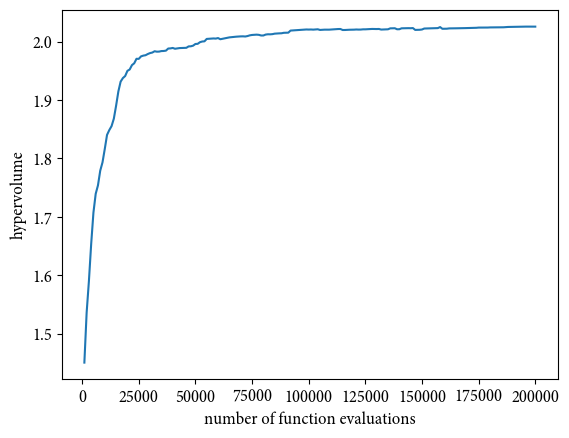

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations")
ax.set_ylabel("hypervolume")
ax.plot(
    list(nfe_archive.keys()), hvs
)  # First 6 distorts the view, giving a wrong sense of convergence
plt.show()

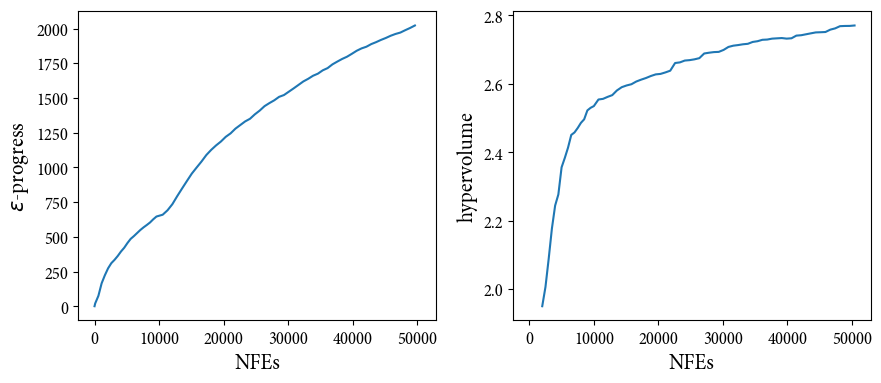

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(9, 4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel("$\epsilon$-progress", fontsize=15)
ax2.plot(nfes[2:], hvs[2:])
ax2.set_ylabel("hypervolume", fontsize=15)

ax1.set_xlabel("NFEs", fontsize=15)
ax2.set_xlabel("NFEs", fontsize=15)
fig.tight_layout()
# plt.grid(False)
plt.savefig("../plots/convergence.svg")
plt.show()

Interestingly epsilon progress suggests there is room for improvement however hypervolume hints at the opposite with **50,000** NFEs!